### MENG 443 Final Project: Pouncing Pogo
1 legged hopping robot simulation and parameter optimization

In [89]:
import numpy as np
import matplotlib.pyplot as plt

In [75]:
def rk4_step(f, x, u, dt):
    """
        Input:
            xdot = f(x) - function to be integrated, passed as f
            x - initial condition to the function 
            dt - time step 
        Output: 
            x[t+dt] 
    """
    # one step of runge-kutta integration, from previous hw
    k_1 = f(x, u)
    k_2 = f(x + dt*k_1/2, u)
    k_3 = f(x + dt*k_2/2, u)
    k_4 = f(x + dt*k_3, u)
    next_x = x + 1/6*dt*(k_1 + 2*k_2 + 2*k_3 + k_4)
    return next_x

### Pogo function definitions

In [76]:
# State of pogo: [x, x_dot, y, y_dot, theta, theta_dot]
# upwards is positive

class Pogo_robot:
    def __init__(self, k, M, l0, init_x, init_xdot, init_y, init_ydot, init_theta, init_thetadot):
        """Initialize state parameters and constant"""
        self.x = init_x
        self.xdot = init_xdot
        self.y = init_y
        self.ydot = init_ydot
        self.theta = init_theta   # radian
        self.thetadot = init_thetadot
        self.k = k
        self.M = M
        self.lk = l0   # maybe check lengths, instantaneous
        self.l0 = l0   # default length
        self.ldot = 0  # initialize with no compression 
        print("Pogo initiated. Spring constant", k, ", mass", M,\
              ", leg length", l0)
        print("Initial [x, xdot, y, ydot, theta, thetadot]:", self.x, self.xdot,\
             self.y, self.ydot, self.theta, self.thetadot)
        
        # Check not initially in contact
        foot_y = self.y - self.lk*np.cos(self.theta - np.pi/2)
        if foot_y < 0:
            print("Pogo seems to be in contact already with ground, do you want to reset it?")
        else:
            print("Ready to hop!")
            print("\|/-~~~~~~~~~~")
    
    def flight(self):
        """Free flight phase (no ground contact)"""
        prev_state = np.array([self.x, self.xdot, self.y, self.ydot, self.theta, self.thetadot, self.lk, self.ldot])    
        self.x += prev_state[1]*dT   # Euler timestep integrate
        self.xdot += 0.0
        self.y += prev_state[3]*dT
        self.ydot += -9.81
        self.theta += prev_state[5]*dT
        self.thetadot += 0  # no change
        self.lk = self.l0   # back to equilibrium point
        self.ldot = 0   
        return 
  
    def is_in_contact(self):
        """
        Flag function to compute if foot lands on the 
        ground (not takeoff check)
        """ 
        foot_y = self.y - self.lk*np.cos(self.theta - np.pi/2)
        #print("Debugging: foot_y", np.round(foot_y,3))
        if foot_y <= 0:
            return True
        else:
            return False 

    def first_contact(self):
        """
        Function with conversion of linear to rotational velocities,
        run once only per contact
        """
        #print("Debugging: contact")
        total_v = ((self.ydot)**2+(self.xdot)**2)**0.5
            
        # tangential (angular) velocity at impact
        v_tangent = -self.ydot*np.sin(self.theta-np.pi/2) - \
                   self.xdot*np.sin(np.pi - self.theta)
        self.thetadot = v_tangent/self.l0
        
        # radial velocity at impact
        self.ldot = -self.ydot*np.cos(self.theta-np.pi/2) - \
                    self.xdot*np.cos(np.pi - self.theta)
        return
    
    def contact(self):
        """Contacted mechanics with the ground"""
        prev_state = np.array([self.x, self.xdot, self.y, self.ydot, self.theta, self.thetadot, self.lk, self.ldot])    
    
        # l_ddot formula: -k/M(l_k - l_k0) - g sin(theta) + l*theta_dot^2 
        l_ddot = -self.k/self.M*(prev_state[6]-self.l0) - 9.81*np.sin(prev_state[4]) + prev_state[6]*(prev_state[5])**2
    
        # theta_ddot formula: -2*l_dot/l*theta_dot - g/l cos(theta)
        theta_ddot = -2*prev_state[7]/prev_state[6]*prev_state[5] - 9.81/prev_state[6]*np.cos(prev_state[4])
    
        # calculate l, theta 
        self.theta    += prev_state[5]*dT  # use previous step's accelerations
        self.thetadot += theta_ddot*dT
        self.lk       += prev_state[7]*dT
        self.ldot     += l_ddot*dT   
    
        # Update x, y and linear velocities, pivoting
        # TODO: check signs
        v_tan = prev_state[6]*prev_state[5]  # tangential velocity 
        self.x += prev_state[1]*dT   # Euler timestep integrate
        self.xdot = v_tan*np.cos(prev_state[4]-np.pi/2)
        self.y += prev_state[3]*dT
        self.ydot = v_tan*np.sin(prev_state[4]-np.pi/2)
    
        return
    
   
    def takeoff_check(self):
        """
        Pogo ground release check function
        Return true if spring is back to equilibrium extension 
        (to back to flight phase)
        """
        if self.lk == self.l0:
            return True
        else:
            return False
    
    def save_state(self, array):
        """ Access and save state information to array """
        array.append([self.x, self.xdot, self.y, self.ydot, self.theta, self.thetadot, self.lk, self.ldot])    
        return

### Pogo hops

In [100]:
dT = 0.001  # seconds, maybe just Euler integrate
state_history = []  # store trajectory

# Initialize Pogo, propagate free flight
Pogo = Pogo_robot(1,1,0.3,0, 0.2, 0.5, -0.3, 2, 0)   # Initialize k,l,m and state
test_time = 20   # total number of timesteps to simulate

time = 0
state = 0   # flag 0 - free fall; 1 - contact
while time < test_time:
    if state == 0: 
        if Pogo.is_in_contact() == False:
            Pogo.flight() 
        else:                      # first contact  
            print("Contacted ground at", time, "step.")
            state = 1
            Pogo.first_contact()   # compute conversion only once
    else:   # state = 1
        if Pogo.takeoff_check() == False:
            Pogo.contact()
        else:
            print("Left the ground at", time, "step.")
            state = 0
            Pogo.flight()  
    
    Pogo.save_state(state_history)
    time += 1
    
    
print(Pogo.is_in_contact())

# Check for ground contact
# 

Pogo initiated. Spring constant 1 , mass 1 , leg length 0.3
Initial [x, xdot, y, ydot, theta, thetadot]: 0 0.2 0.5 -0.3 2 0
Ready to hop!
\|/-~~~~~~~~~~
Contacted ground at 8 step.
Left the ground at 9 step.
Contacted ground at 10 step.
Left the ground at 11 step.
Contacted ground at 12 step.
Left the ground at 13 step.
Contacted ground at 14 step.
Left the ground at 15 step.
Contacted ground at 16 step.
Left the ground at 17 step.
Contacted ground at 18 step.
Left the ground at 19 step.
True


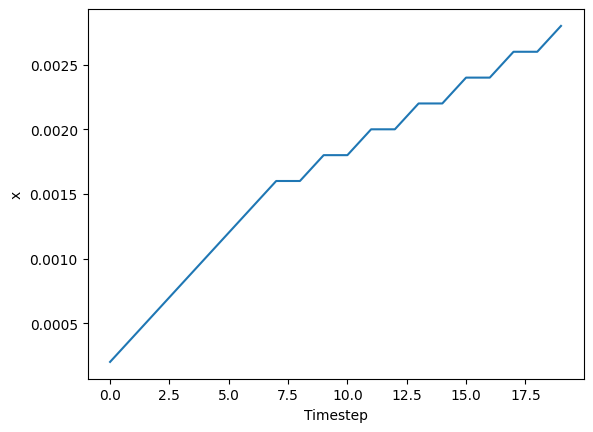

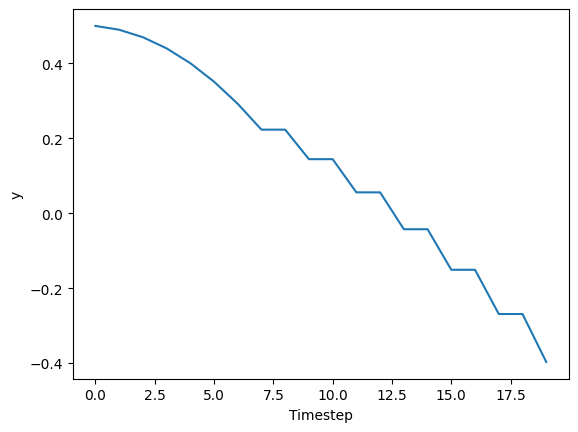

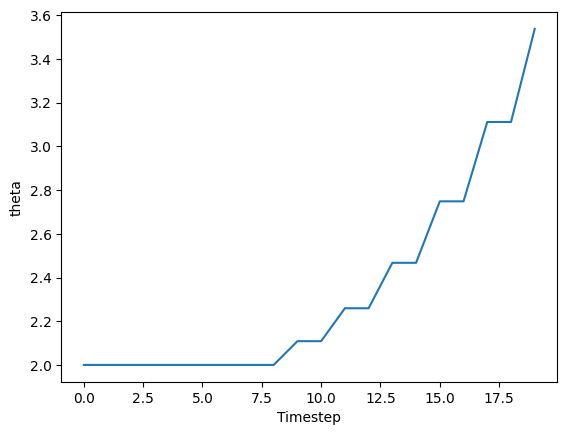

In [99]:
# Plot
x_history = []
for i in range(test_time):
    x_history.append(state_history[i][0])

plt.plot(x_history)
plt.xlabel("Timestep")
plt.ylabel("x")
plt.show()

y_history = []
for i in range(test_time):
    y_history.append(state_history[i][2])

plt.plot(y_history)
plt.xlabel("Timestep")
plt.ylabel("y")
plt.show()

theta_history = []
for i in range(test_time):
    theta_history.append(state_history[i][4])

plt.plot(theta_history)
plt.xlabel("Timestep")
plt.ylabel("theta")
plt.show()

